In [1]:
###############################
#Started on Thu January 23 2020
#@author: Jonathan Frame
###############################
# This program is designed to generate a synthetic dataset of atmospheric forcing conditions that 
# match the NLDAS data from 1980 - 2014.
# The synthetic record can be extended out as far as the user likes,
# and the user can add nonstationary conditions by adjusting the Parameters controlling the distributions.

In [2]:
import numpy as np
import pandas as pd
import time
import datetime as dt
import sys 
import os
import matplotlib.pyplot as plt
import scipy.stats as ss
from metsim import MetSim

In [3]:
# PROGRAM INITIALIZATION OPTIONS

ymi = 'yearmonth' # Year month index
#  Synthetic data generating parameters
OF = 2 # A multiplier (integer) for continuing out the synthetic forcing data record past the original NLDAS.
PRECIP_PARAMETER1 = 0.75 #  Synthetic data generating parameters
PRECIP_PARAMETER2 = 0.25
TEMP_PARM1 = 0.25
TEMP_PARM2 = 5.8
TEMP_PARM3 = 0.09
TEMP_PARM4 = 5.2
TEMP_PARM5 = 0.13
nGauges = 673 # Setting nGauges to be known number of gauges in CAMELS
count_basins = 0 # just a value to keep track of loops
max_basins = 1 # Stopping the loop after this many basins, for testing the script.
np.set_printoptions(threshold=sys.maxsize)# print options for generating the results files.

In [4]:
#Store all attributes. Really just need basin area, but the rest might come in handy.
att_path = "/home/NearingLab/data/camels_attributes_v2.0/camels_all.txt"
attributes = pd.read_csv(att_path, sep=";")
attributes.set_index('gauge_id', inplace=True)
#data directory path
df_path = "/home/NearingLab/projects/jmframe/CAMELS_synthData/nldas_forcing/"

In [5]:
dataSample = pd.read_csv(df_path+'13240000_lump_nldas_forcing_leap.txt',sep='\t| ',header=3, engine='python')
dataSample.head()

,Year,Mnth,Day,Hr,Dayl(s),PRCP(mm/day),SRAD(W/m2),SWE(mm),Tmax(C),Tmin(C),Vp(Pa)
0,1980,1,1,12,31104.00,10.83,111.34,0.0,-2.41,-2.41,506.34
1,1980,1,2,12,31104.00,0.63,175.14,0.0,-4.70,-4.70,409.05
2,1980,1,3,12,31206.78,2.93,185.01,0.0,-3.56,-3.56,439.31
3,1980,1,4,12,31446.44,5.14,129.62,0.0,-4.07,-4.07,441.41
4,1980,1,5,12,31449.60,30.66,95.43,0.0,-2.73,-2.73,479.02


13240000_lump_nldas_forcing_leap.txt
All the data in this catchment looks good to go


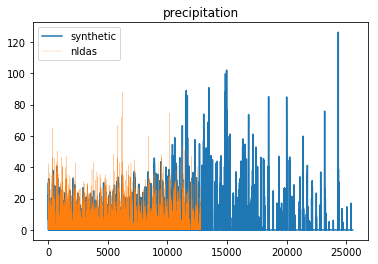

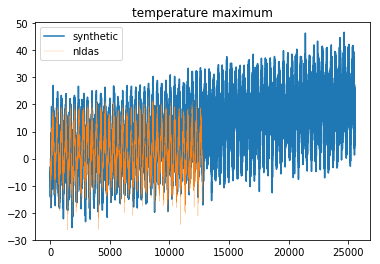

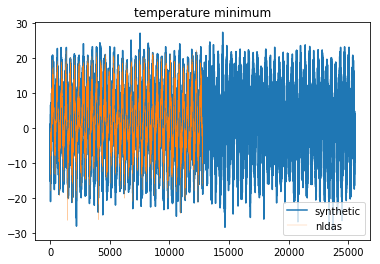

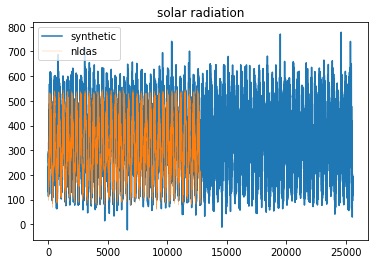

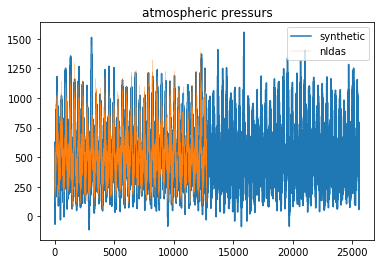

In [6]:
count_basins = 0 # just a value to keep track of loops
# Loop through all the files in the forcing data directory.
for filename in os.listdir(df_path):
    print(filename)

    # the known location of the gauge ids in the files
    gauge_id = filename[0:8]

    # Confirm that there is a corresponding precipitation gauge to the discharge.
    if int(gauge_id) in attributes.index:
        # Get latitude and longitude. We will need these for MetSim.
        Latitude = attributes.loc[int(gauge_id),'gauge_lat']
        Longitude = attributes.loc[int(gauge_id),'gauge_lon']
        Elevation = attributes.loc[int(gauge_id),'elev_mean']
    else:
        print("gauge_id: " + gauge_id)
        print("WARNING::this catchment is not in the CAMELS attributes: ")
        print("Moving on to the next one...")
        continue
        
    dataF = pd.read_csv(df_path+filename,sep='\t| ',header=3, engine='python')

    # This loop has two purposes right now.
    # 1) to get some monthly ids for generating month statistics down the road
    # 2) for checking the data for missing values.
    badData=0   # a boolean to switch on if a value is bad.
    ym=[]       # ym=yearmonth, to be used for indexing values for monthly statistics
    ym_new=[]   # a set of uniqu ym values.
    for t in range(dataF.shape[0]):
        yearmonthasinteger=int(str(dataF.iloc[t,0])+str(dataF.iloc[t,1]).zfill(2))
        if yearmonthasinteger not in ym:
            ym_new.append(yearmonthasinteger)
        ym.append(yearmonthasinteger)

        for v in range(5,11):
            if dataF.iloc[t,v] < -990:
                print("gauge_id: " + gauge_id)
                print('bad data at time/variable',[t,v])
                badData += 1
    if badData == 0:
        print('All the data in this catchment looks good to go')
    else:
        print('bad values in the data =', badData)

    dataF.insert(4, ymi, ym)
    origColNames=list(dataF.columns)
    
    # CHange the column names, to make them easier to work with
    dataF.columns = dataF.columns.str.strip().str.lower().str.replace('/', '')
    dataF.columns = dataF.columns.str.strip().str.replace('(', '').str.replace(')', '')
    forcingCol=list(dataF.columns)
    
    # Get the statistics for each month in the data record.
    dataFave = dataF.groupby(ymi, as_index=True).mean() 
    dataFmin = dataF.groupby(ymi, as_index=True).min()
    dataFmax = dataF.groupby(ymi, as_index=True).max()
    dataFstd = dataF.groupby(ymi, as_index=True).std()
    # Get the statistics for days in the month that it is raining.
    dataPave = dataF[dataF.prcpmmday > 1].groupby(ymi, as_index=True).mean()
    dataPmin = dataF[dataF.prcpmmday > 1].groupby(ymi, as_index=True).min()
    dataPmax = dataF[dataF.prcpmmday > 1].groupby(ymi, as_index=True).max()
    dataPstd = dataF[dataF.prcpmmday > 1].groupby(ymi, as_index=True).std()
    dataPsum = dataF[dataF.prcpmmday > 1].groupby(ymi, as_index=True).sum()
    # Get the statistics for days in the month that it is NOT raining.
    dataP0ave = dataF[dataF.prcpmmday == 0].groupby(ymi, as_index=True).mean()
    dataP0min = dataF[dataF.prcpmmday == 0].groupby(ymi, as_index=True).min()
    dataP0max = dataF[dataF.prcpmmday == 0].groupby(ymi, as_index=True).max()
    dataP0std = dataF[dataF.prcpmmday == 0].groupby(ymi, as_index=True).std()

    # Make dataframe for the number of days in the month, and number of rainy days
    dataFcnt = dataF.groupby(ymi, as_index=True).count() # days in month
    dataPcnt = dataF[dataF.prcpmmday > 1].groupby(ymi, as_index=True).count() # rain days

    # to get the percent of rainy days
    dataFcnt = pd.DataFrame(dataFcnt[forcingCol[0]]).rename(columns = {'year':'Ndays'})
    dataPcnt = pd.DataFrame(dataPcnt[forcingCol[0]]).rename(columns = {'year':'Rdays'})
    dataPsum = pd.DataFrame(dataPsum[forcingCol[6]]).rename(columns = {'prcpmmday':'prcpmmmonth'})

    # Some months have zero raining days, and got cut out. Put them back in with zero.
    for ym in dataFcnt.index.values:
        if ym not in dataPcnt.index.values:
            df_temp = pd.DataFrame({'Rdays':0}, index=[ym], columns=['Rdays'])
            dataPcnt = dataPcnt.append(df_temp, ignore_index=False, sort=True)
            df_temp = pd.DataFrame({'prcpmmmonth':0}, index=[ym], columns=['prcpmmmonth'])
            dataPsum = dataPsum.append(df_temp, ignore_index=False, sort=True)
            dataPave = dataPave.append(dataP0ave.loc[ym])
            dataPmin = dataPmin.append(dataP0min.loc[ym])
            dataPmax = dataPmax.append(dataP0max.loc[ym])
            dataPstd = dataPstd.append(dataP0std.loc[ym])

    dataPcnt['percentRainday'] = dataPcnt['Rdays']/np.maximum(1,dataFcnt['Ndays'])

    # Generate a synthetic record of NLDAS matching forcing data. 
    synthData = dataF.copy()
    synthData = pd.concat([synthData]*OF, ignore_index=True)
    
    NS1 = np.linspace(0,20,synthData.shape[0])
    NS2 = np.linspace(0,1,dataF.shape[0])
    NS3 = np.linspace(0,0.65,synthData.shape[0])
    NS4 = np.linspace(1,4,synthData.shape[0])
    for i in range(dataF.shape[0]):
        NS1[i] = NS1[i]*NS2[i]
        NS3[i] = NS3[i]*NS2[i]
        NS4[i] = NS4[i]*NS2[i]
    delete = 0.7
    delete2= 1.5

    # Main loop to generate the synthetic data.
    for t in range(synthData.shape[0]):            
        # make the first values equal to the average. 
        # Since the calcs depend on the previous values.
        if t == 0:
            ym = int(synthData.iloc[t][ymi])
            Sdatetime = dt.datetime(synthData.iloc[t, 0], synthData.iloc[t, 1], synthData.iloc[t, 2])
            for v in range(5,11):
                synthData.iloc[t, v] = dataFave.loc[ym, forcingCol[v]]
        if t > 0:
            
            # Deal with the dates. Use Date time to keep track, and fill in the year, month, day values.
            Sdatetime += dt.timedelta(days=1)
            synthData.iloc[t, 0] = Sdatetime.year
            synthData.iloc[t, 1] = Sdatetime.month
            synthData.iloc[t, 2] = Sdatetime.day
            if t < synthData.shape[0]:
                ym = int(synthData.iloc[t][ymi])
            # When the synthetic data leaves the 1980-2014 period, then use the stats from year-25 years ago.
            # Example, January 2015 will use the stats from January 1980, July 2020 will use July 1985
            else:
                ym = int(str(synthData.iloc[t, 0]-25)+str(synthData.iloc[t, 1]).zfill(2))
                synthData.iloc[t, 4]
                
            # Then go through and fill in all the values with the probabilistic values.
            p = dataPcnt.loc[ym, 'percentRainday']
            pwd = (PRECIP_PARAMETER1) * p
            pww = (PRECIP_PARAMETER2) + pwd
            a = dataPave.loc[ym, forcingCol[6]]
            s = dataPstd.loc[ym, forcingCol[6]]

            # Statistics to set the precipitation value.
            PmWm = dataPsum.loc[ym, 'prcpmmmonth']/np.maximum(1,dataPcnt.loc[ym,'Rdays'])
            x1 = np.maximum(0.1,-2.16+1.83*PmWm)
            x2 = np.maximum(1,PmWm/x1)
            # Statistics to set the Temperature value.
            Tx = dataFave.loc[ym, 'tmaxc']
            Tn = dataFave.loc[ym, 'tminc']
            t1 = Tx+TEMP_PARM1*PmWm*(Tx-Tn)  + NS1[t]                                            # MEAN
            t2 = np.maximum(0.5, TEMP_PARM2-TEMP_PARM3*(Tx+TEMP_PARM1*(Tx-Tn)))                  # STDEV
            t2 = np.maximum(0.3, t2 - delete)
            t3 = Tx+TEMP_PARM1*(PmWm-1)*(Tx-Tn)   + NS1[t]                                       # MEAN
            t4 = np.maximum(0.5, TEMP_PARM2-TEMP_PARM3*(Tx+TEMP_PARM1*(PmWm-1)*(Tx-Tn)))         # STDEV
            t4 = np.maximum(0.3, t4 - delete)
            t5 = Tn                                                                              # MEAN
            t6 = np.maximum(0.5, TEMP_PARM4-TEMP_PARM5*t5)                                       # STDEV
            
            # Statistics to set the daily NET RADIATION value
            r1 = dataFave.loc[ym, 'sradwm2'] #MEAN
            r2 = dataFstd.loc[ym, 'sradwm2'] #STDEV
            
            # Statistics to set the daily atmospheric value
            p1 = dataFave.loc[ym, 'vppa'] #MEAN
            p2 = dataFstd.loc[ym, 'vppa'] #STDEV
            
            # Check if it rained the day before
            # probability of rain today depends on yesterday.
            if synthData.iloc[t-1,6] == 0:                              #Rain yesterday
                if pww <= np.random.random_sample([1]) - NS3[t]:   #Rain today
                    synthData.loc[t, 'prcpmmday'] = np.random.gamma(x1,x2)       #Precipitation
                    synthData.loc[t, 'tmaxc'] = np.random.normal(t1,t2)#Temperature MAX
                else:                                                   #Dry today
                    synthData.loc[t, 'prcpmmday'] = 0                            #Precipitation
                    synthData.loc[t, 'tmaxc'] = np.random.normal(t3,t4)#Temperature MAX
            else:                                                       #Dry yesterday
                if pwd <= np.random.random_sample([1]) -  NS3[t]:   #Wet today
                    synthData.loc[t, 'prcpmmday'] = np.random.gamma(x1,x2)*NS4[t]       #Precipitation
                    synthData.loc[t, 'tmaxc'] = np.random.normal(t1,t2)#Temperature MAX
                else:                                                   #Dry today
                    synthData.loc[t, 'prcpmmday'] = 0                            #Precipitation
                    synthData.loc[t, 'tmaxc'] = np.random.normal(t3,t4)#Temperature MAX
                    
            synthData.loc[t, 'tminc'] = np.random.normal(t5,t6)        #Temperature MIN

            # Nearing(2013) page 165
            # "A set of Dm values for daily net radiation was sampled by the Gaussian distribution 
            # with mean Rm and variance r2 R, and the samples were ordered so that the highest value 
            # of net radiation oc- curred on the day with the highest mean temperature, and so forth"
            if synthData.loc[t, 'day'] == dataFcnt.loc[ym, 'Ndays']: # Loop through on last day of month.
                ndays = dataFcnt.loc[ym, 'Ndays']  # To index the synthetic data record, to place solar rad
                sradsSynth = np.random.normal(r1,r2,ndays)  #generate Solar Radiation values
                seqSrads = sorted(sradsSynth)                # sort those values, to match up with temp
                tempSynth = synthData.loc[t-(ndays-1):t,'tmaxc'] # Get the max temp values 
                seqTemp = sorted(tempSynth)                         # sort those values, to match up with temp
                indexTemp = [seqTemp.index(vvv) for vvv in tempSynth] #index the temperature data, to match rad.
                synthData.loc[t-(ndays-1):t, 'sradwm2'] = [seqSrads[i] for i in indexTemp] # Place rad values.
                
            
            #https://en.wikipedia.org/wiki/Vapour-pressure_deficit
            synthData.loc[t, 'vppa'] = np.random.normal(p1,p2)        #Vapor pressure deficit
            A = -1.044*10**4
            B = -11.29
            C = -2.7*10**-2
            D = 1.289*10**-5
            E = -2.478*10**-9
            F = 6.456
            Tc = (synthData.loc[t, 'tminc'] + synthData.loc[t, 'tmaxc'])/2
            T = (Tc - 32) * (5/9) + 459.67
            vpsat = exp(A/T + B + C*T + D*T**2 + E*T**3 + F*log(T))
            VPD = vpsat * (1 - RH / 100)
            
    # Some plotting for testing the data generation.
    plt.plot(synthData['prcpmmday'], label='synthetic')
    plt.plot(dataF['prcpmmday'], label='nldas', linewidth=0.2)
    plt.legend()
    plt.title('precipitation')
    plt.show()
    plt.plot(synthData['tmaxc'], label='synthetic')
    plt.plot(dataF['tmaxc'], label='nldas', linewidth=0.2)
    plt.legend()
    plt.title('temperature maximum')
    plt.show()
    plt.plot(synthData['tminc'], label='synthetic')
    plt.plot(dataF['tminc'], label='nldas', linewidth=0.2)
    plt.legend()
    plt.title('temperature minimum')
    plt.show()
    plt.plot(synthData['sradwm2'], label='synthetic')
    plt.plot(dataF['sradwm2'], label='nldas', linewidth=0.2)
    plt.legend()
    plt.title('solar radiation')
    plt.show()
    plt.plot(synthData['vppa'], label='synthetic')
    plt.plot(dataF['vppa'], label='nldas', linewidth=0.2)
    plt.legend()
    plt.title('atmospheric pressurs')
    plt.show()
    count_basins+=1
    if count_basins >= max_basins:
        break

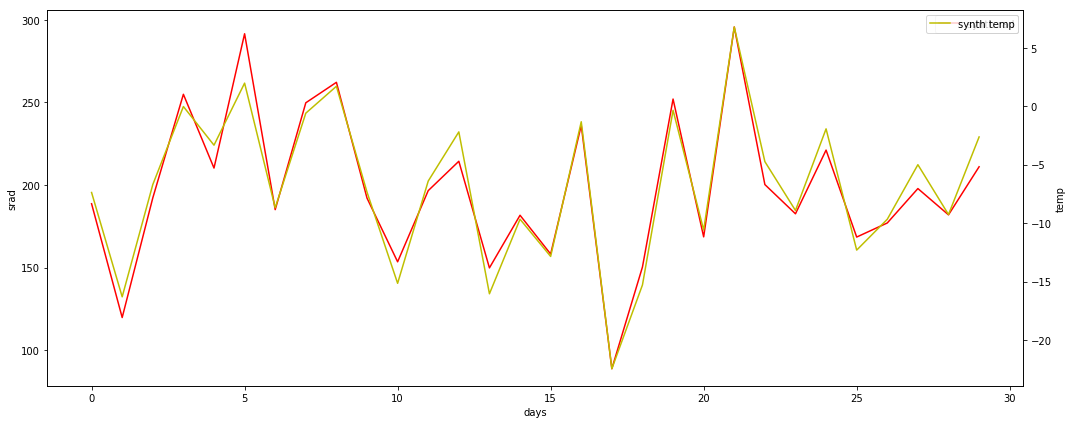

In [28]:
# Check that the solar radiation and the temperature values match
data1=synthData['sradwm2'].iloc[0:30]
label1='synth rad'
data2=dataF['sradwm2'].iloc[0:30]
label2='nldas rad'
data3=synthData['tmaxc'].iloc[0:30]
label3='synth temp'
fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.set_xlabel('days')
ax1.set_ylabel('srad')
ax1.plot(data1, c='r', label=label1)
#ax1.plot(data2, c='b', label=label2)
plt.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('temp')  # we already handled the x-label with ax1
ax2.plot(data3, c='y', label=label3)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()
plt.show()

In [ ]:
# rest of the workflow
dates = pd.date_range('1971/01/01', '1971/12/31')
params = {
    # Run parameters, timestep, start, and stop dates
    'time_step'    : "60",       
    'start'        : dates[0],
    'stop'         : dates[-1],
    # Where all of our input files are
    'forcing'      : './input/green_river_forcing.nc',     
    'domain'       : './input/green_river_domain.nc',
    'state'        : './input/green_river_state.nc',
    # The format of the forcing data
    'forcing_fmt'  : 'netcdf',
    # Specification of the output
    'out_dir'      : './output',
    'output_prefix': 'green_river',
    # Scheduler to use for job management - see text above for more information
    'scheduler'    : 'threading',
    # This is analagous to the [chunks] section from the config file
    'chunks'       : 
        {'hru': 3},
    # This is analagous to the [forcing_vars] section from the config file
    'forcing_vars' : 
        {'prcp' : 'prec', 'tmax': 't_max', 'tmin': 't_min'},
    # This is analagous to the [state_vars] section from the config file
    'state_vars'   : 
        {'prcp' : 'prec', 'tmax': 't_max', 'tmin': 't_min'},
    # This is analagous to the [domain_vars] section from the config file
    'domain_vars'  : 
        {'elevation': 'elev', 'latitude': 'lat', 'longitude': 'lon', 'mask': 'mask'}
    }

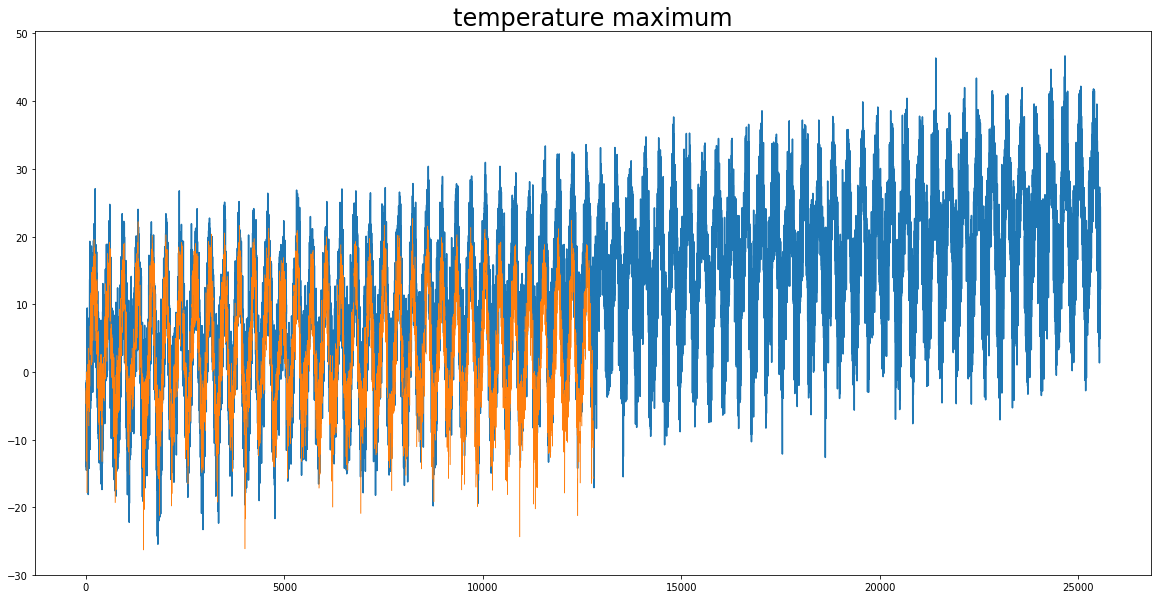

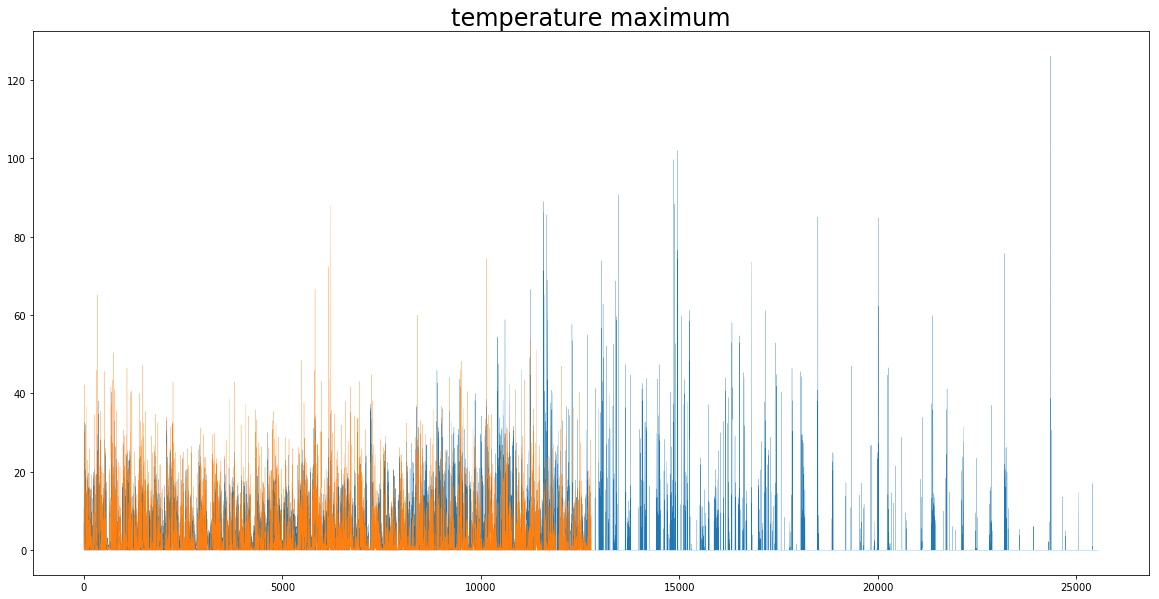

In [7]:
plt.figure(figsize=(20,10))
plt.plot(synthData['tmaxc'], label='synthetic')
plt.plot(dataF['tmaxc'], label='nldas', linewidth=0.5)
plt.title('temperature maximum', fontsize=24)
plt.show()
plt.figure(figsize=(20,10))
plt.plot(synthData['prcpmmday'], label='synthetic', linewidth=0.2)
plt.plot(dataF['prcpmmday'], label='nldas', linewidth=0.2)
plt.title('temperature maximum', fontsize=24)
plt.show()

In [50]:
t2

6.207003225806451